# Lab 12 - Natural Language Processing - Towards Attention


Dominik Gaweł

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dg7s/Machine-Learning/blob/main/hw/Semantic_Vector_Relationships.ipynb)
-------------------------------

# **Homework Assignment: Is a *queen* really just a *king*, minus a *man*, plus a *woman*?**

--------------



In class, we dealt with **embeddings** trained for **sentiment classification**. These embeddings are optimized to separate *positive* from *negative* expressions and **do not encode deeper semantic information**.

However, in modern natural language processing, there exist other embeddings — such as those from **BERT**, **word2vec**, or **GloVe** — that **do capture semantic structure**. These models are trained on large corpora, and their embeddings often allow for meaningful **vector arithmetic**, like the famous:

```
embedding("king") - embedding("man") + embedding("woman") ≈ embedding("queen")
```

This homework explores **semantic vector relationships** using such pretrained embeddings.

## **The Objective**

Your task is to:

1. Construct semantic classes of word pairs.
2. Visualize them using PCA.
3. Explore arithmetic operations in embedding space.

## **Tasks & Deliverables**

### 1. **Semantic Pair Classes**

- You must gather **at least 10 classes** of semantically related word pairs.
- Each class must contain **at least 5 pairs**.
- That gives a **minimum total of 100 unique words** (10 classes x 5 pairs x 2 words per pair).

Two example classes:

**Class 1: Gender**

- (king, queen)
- (man, woman)
- (doctor, nurse)
- (prince, princess)
- *(you must add one more)*

**Class 2: Verb tense (past tense)**

- (bring, brought)
- (get, got)
- (like, liked)
- *(you must add two more)*

**Your job:**

- Invent or search for **at least 10 such classes**, including the examples above.
- Each class must be conceptually coherent.
- Other examples: singular/plural, country/capital, comparative/superlative, tool/user, job/object, etc.

### 2. **Global PCA (Across All Words)**

- Use PCA to reduce the **entire set of 100 word embeddings** to 2D, and plot it.
- Plot the additional **10 separate charts**, one for each class.
  - Each chart should display only the 10 words (5 pairs) of the given class.
- Points should be labeled with the words themselves.

### 3. **Local PCA (Per Class)**

- For each class (10 total), perform PCA **only** on the 10 words of that class.
- Plot these class-wise PCA visualizations as separate charts.
- Again, points should be labeled with the words.

**Total: 21 charts**
(1 global plot with 100 words + 10 global-space class plots + 10 local PCA class plots)

Charts should be presented in a self-explanatory manner with clear labels.

### 4. **Embedding Arithmetic**

For each class, choose **one example pair** (e.g., (king, queen)) and perform the operation:

```
embedding(B) - embedding(A) + embedding(C)
```

Where A and B form a known pair, and C is another base word.
For example:

```
embedding("king") - embedding("man") + embedding("woman")
```

* For each such result vector, find the **5 closest word embeddings** (using cosine similarity or Euclidean distance).
* Print the top 5 neighbors **with their distances**.
* Do this **once per class** (i.e., 10 times).

This will make it possible to verify if
 ```
embedding("queen") ≈ embedding("king") - embedding("man") + embedding("woman")
```
for the *gender*-related class.


### 5. **Discussion**

* Analyze and interpret your 21 plots.
* Discuss whether the vector relationships are preserved.
* Does PCA capture semantic differences?
* Are the closest words from the arithmetic meaningful?
* What kinds of relationships are captured, and what are not?
* Are some classes better behaved than others?


### 6. **Publish on GitHub**  
   - Place the Colab notebook in your **GitHub repository** for this course.
   - In your repository’s **README**, add a **link** to the notebook and also include an **“Open in Colab”** badge at the top of the notebook so it can be launched directly from GitHub.


## Acknowledgments

*This homework assignment was inspired by an idea from my master's student **Andrzej Małek**, to whom I would like to express my thanks.*



# Semantic PCA & Arithmetic (using Gensim‐downloaded embeddings)

We will:
1. Define 10 semantic classes (5 pairs each → 100 words).
2. Load a pretrained embedding via `gensim.downloader` (GloVe-100d).
3. Perform Global PCA (100 words).
4. For each class:
   - Plot in the _global_ PCA space.
   - Plot a _local_ PCA for that class.
5. Do one embedding‐arithmetic per class and report top-5 nearest neighbors.


## 1. Define Semantic Classes

Each class has 5 word‐pairs (10 words), total 100 unique tokens.


In [3]:
classes = {
    "Gender": [
        ("king",    "queen"),
        ("man",     "woman"),
        ("prince",  "princess"),
        ("actor",   "actress"),
        ("father",  "mother")
    ],
    "Verb_Tense_Past": [
        ("bring", "brought"),
        ("go",    "went"),
        ("take",  "took"),
        ("run",   "ran"),
        ("eat",   "ate")
    ],
    "Singular_Plural": [
        ("cat",   "cats"),
        ("dog",   "dogs"),
        ("car",   "cars"),
        ("child", "children"),
        ("mouse", "mice")
    ],
    "Country_Capital": [
        ("france",  "paris"),
        ("japan",   "tokyo"),
        ("italy",   "rome"),
        ("canada",  "ottawa"),
        ("poland",  "warsaw")
    ],
    "Comparative_Superlative": [
        ("small",    "smaller"),
        ("big",      "bigger"),
        ("fast",     "faster"),
        ("happy",    "happier"),
        ("angry",    "angrier")
    ],
    "Tool_User": [
        ("pen",      "writer"),
        ("hammer",   "carpenter"),
        ("brush",    "painter"),
        ("computer", "programmer"),
        ("camera",   "photographer")
    ],
    "Job_Object": [
        ("teacher",  "lesson"),
        ("chef",     "meal"),
        ("driver",   "vehicle"),
        ("farmer",   "crop"),
        ("doctor",   "patient")
    ],
    "Opposites": [
        ("hot",    "cold"),
        ("tall",    "little"),
        ("light",  "dark"),
        ("joyful",  "sad"),
        ("rapid",   "slow")
    ],
    "Currency_Country": [
        ("usa",    "dollar"),
        ("russia",  "ruble"),
        ("uk",     "pound"),
        ("india",  "rupee"),
        ("china",  "yuan")
    ],
    "Animal_Young": [
        ("bear",   "cub"),
        ("duck",   "duckling"),
        ("cow",   "calf"),
        ("goat",  "kid"),
        ("sheep", "lamb")
    ]
}

all_words = sorted({w for pairs in classes.values() for pair in pairs for w in pair})
assert len(all_words) == 100

## 2. Load Pretrained Embeddings via Gensim

We’ll fetch GloVe-100d from `gensim.downloader`. If any word is missing, we’ll print it.

In [2]:
%pip install --quiet gensim==4.3.1 scipy==1.10.1 scikit-learn matplotlib

**Note:** After running the cell above, please **restart the Colab runtime** to ensure that all package versions and dependencies are correctly updated.

In [4]:
import gensim.downloader as api
import numpy as np

model = api.load("glove-wiki-gigaword-100")

embeddings = {}
missing = []
for w in all_words:
    if w in model:
        embeddings[w] = model[w]
    else:
        missing.append(w)

print(f"Loaded embeddings for {len(embeddings)}/{len(all_words)} words.")
if missing:
    print("Missing tokens:", missing)

Loaded embeddings for 100/100 words.


## 3. Global PCA (100 words)

Fit PCA on all 100 embeddings → 2D coordinates → one scatter + labels.


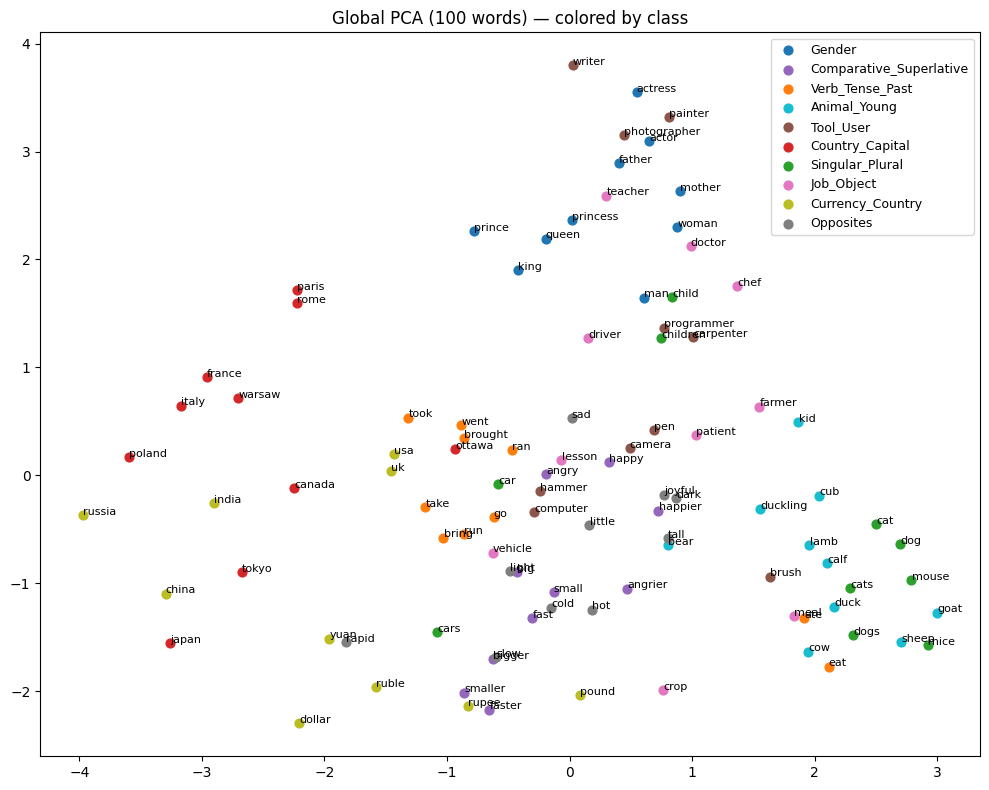

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


word_list = sorted(embeddings.keys())
X = np.vstack([embeddings[w] for w in word_list])

pca_global = PCA(n_components=2)
coords_global = pca_global.fit_transform(X)

word_to_class = {}
for class_name, pairs in classes.items():
    for a, b in pairs:
        a, b = a.lower(), b.lower()
        if a not in word_to_class:
            word_to_class[a] = class_name
        if b not in word_to_class:
            word_to_class[b] = class_name

class_names = list(classes.keys())
cmap = plt.get_cmap("tab10")
class_to_color = {class_names[i]: cmap(i) for i in range(len(class_names))}

plt.figure(figsize=(10, 8))

plotted_classes = set()

for i, w in enumerate(word_list):
    cls = word_to_class.get(w, None)
    color = class_to_color[cls] if cls is not None else "lightgray"
    if cls not in plotted_classes:
        plt.scatter(coords_global[i, 0], coords_global[i, 1],
                    s=40, color=color, label=cls)
        plotted_classes.add(cls)
    else:
        plt.scatter(coords_global[i, 0], coords_global[i, 1],
                    s=40, color=color)
    plt.text(coords_global[i, 0] + 0.002, coords_global[i, 1] + 0.002,
             w, fontsize=8)

plt.title("Global PCA (100 words) — colored by class")
plt.legend(loc="upper right", fontsize=9)
plt.tight_layout()
plt.show()


## 4. Per-Class Global‐Space PCA Plots

For each of the 10 classes, plot only its 10 words projected into the _same_ global PCA space.


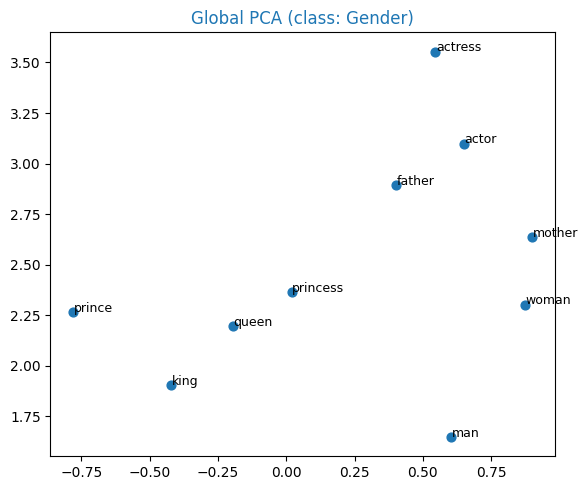

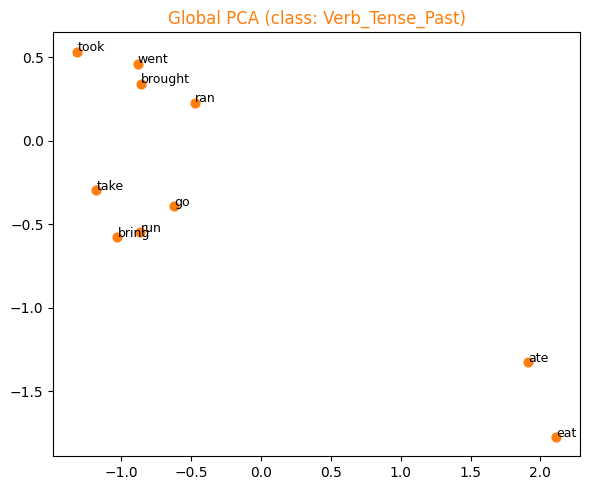

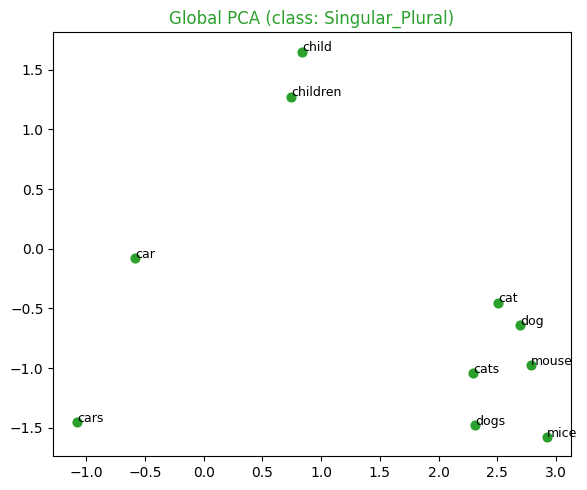

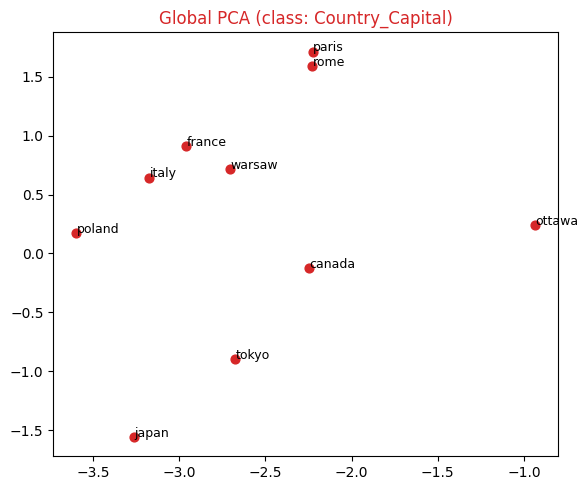

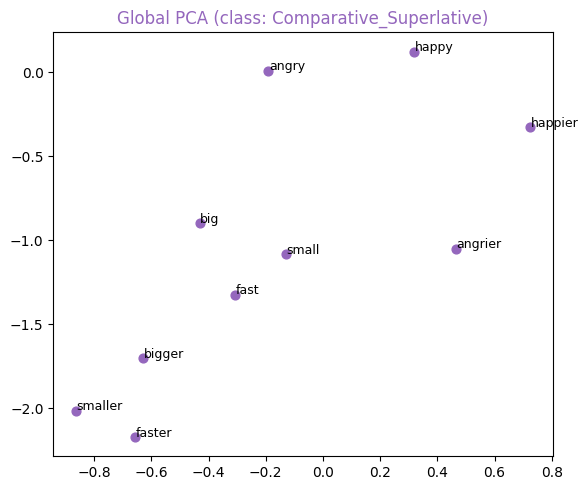

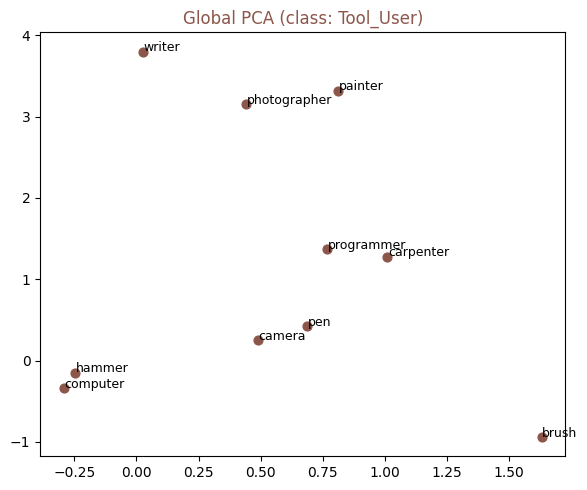

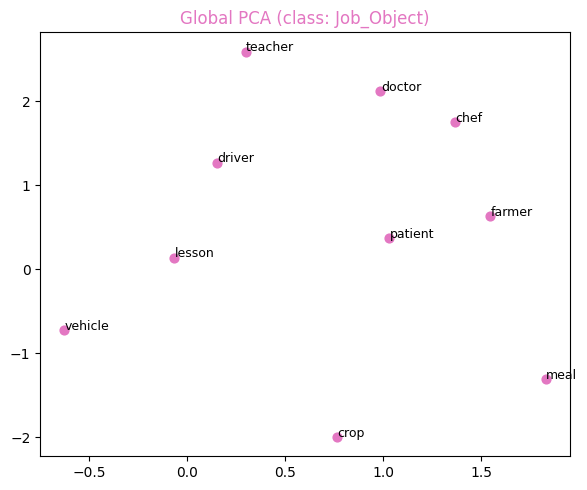

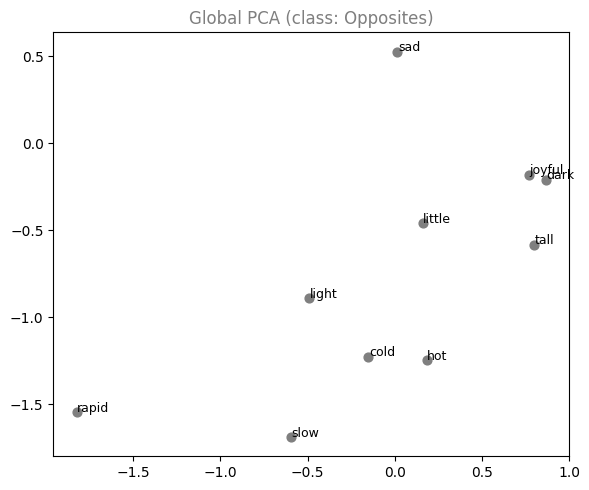

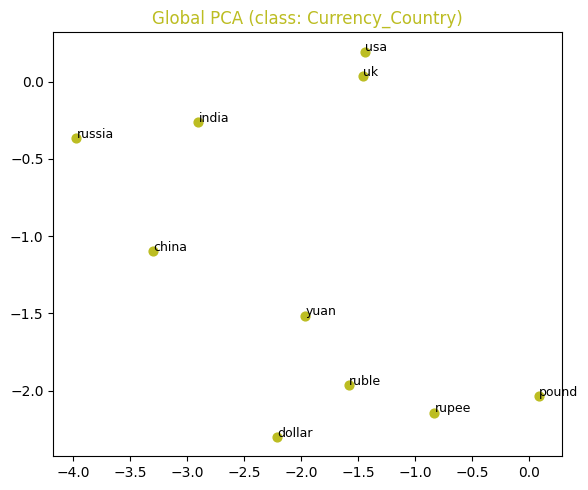

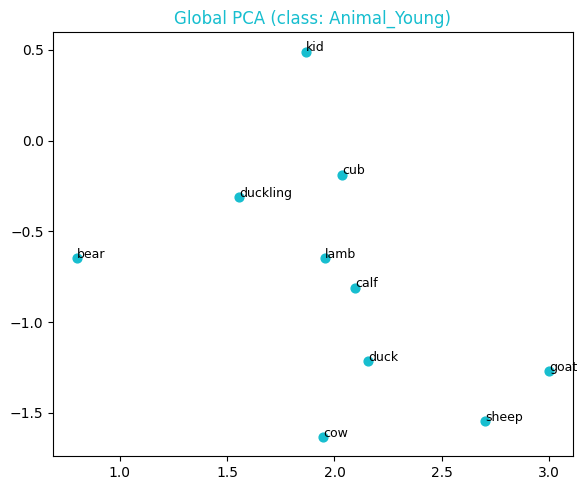

In [6]:
for class_name, pairs in classes.items():
    words = [w for pair in pairs for w in pair]
    words = [w for w in words if w in embeddings]
    indices = [word_list.index(w) for w in words]
    coords = coords_global[indices]
    color = class_to_color[class_name]

    plt.figure(figsize=(6, 5))
    for idx, w in enumerate(words):
        x, y = coords[idx]
        plt.scatter(x, y, s=40, color=color)
        plt.text(x + 0.002, y + 0.002, w, fontsize=9)

    plt.title(f"Global PCA (class: {class_name})", color=color)
    plt.tight_layout()
    plt.show()

## 5. Per-Class Local PCA


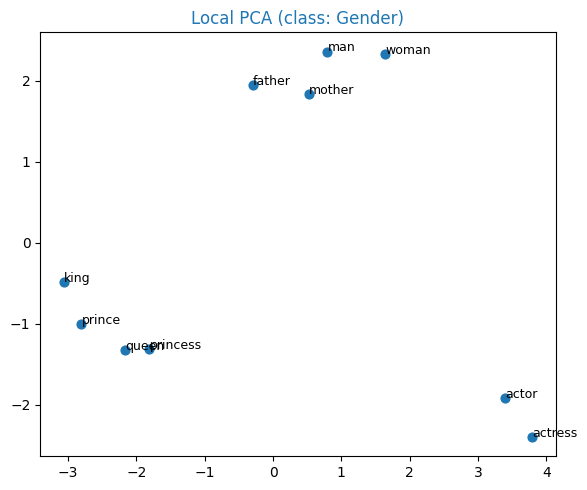

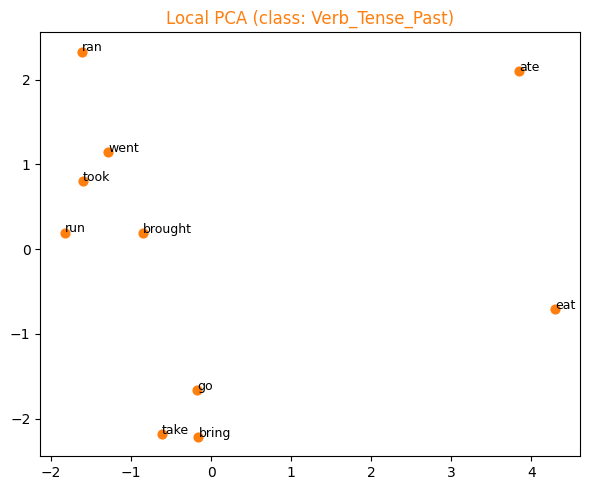

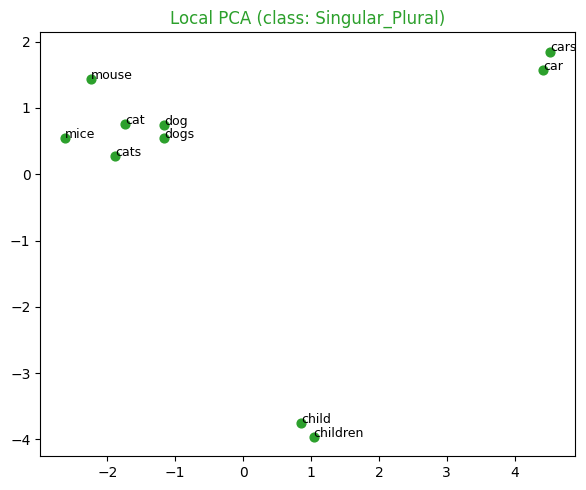

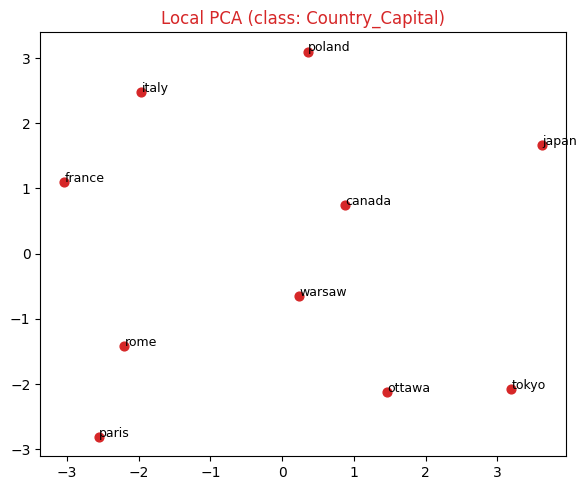

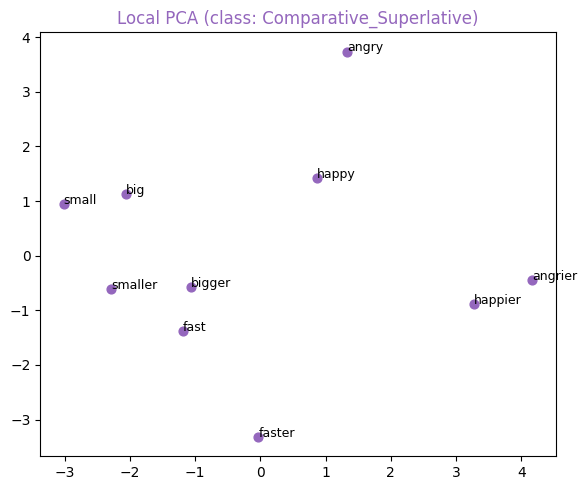

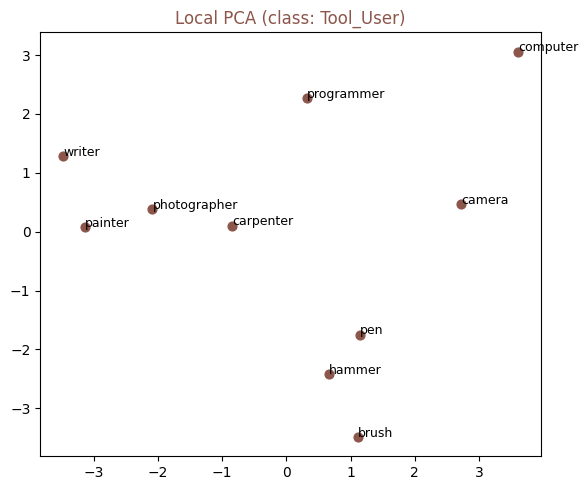

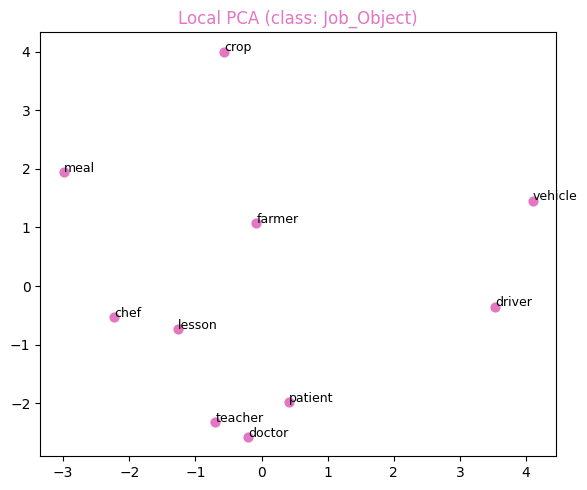

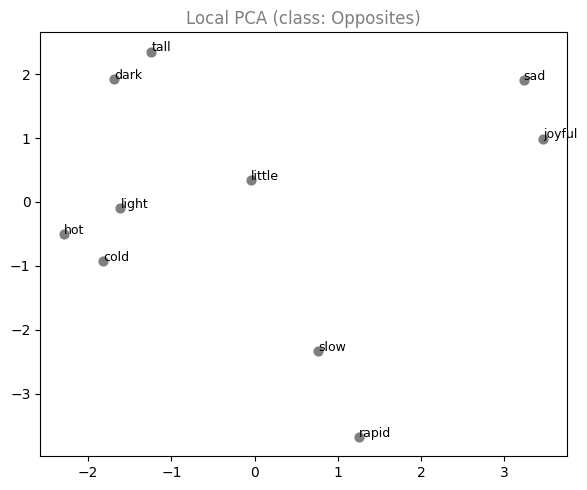

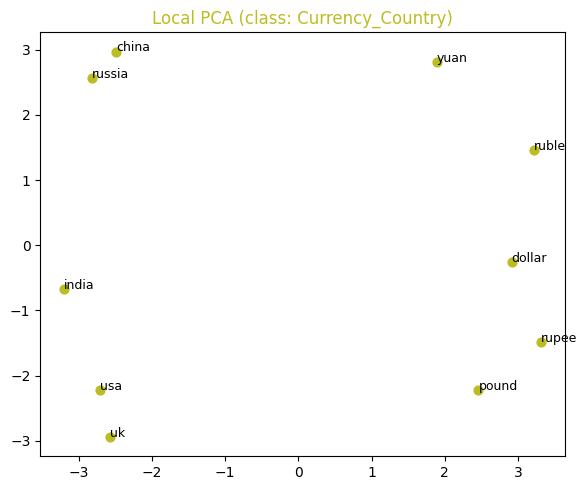

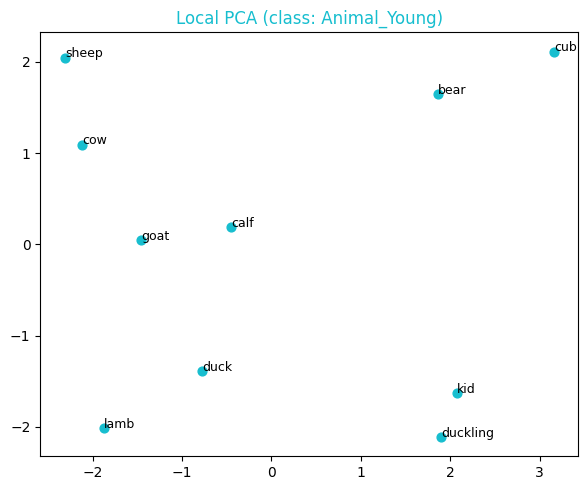

In [7]:
for class_name, pairs in classes.items():
    words = [w for pair in pairs for w in pair]
    words = [w for w in words if w in embeddings]
    M = np.vstack([embeddings[w] for w in words])

    pca_loc = PCA(n_components=2)
    coords_loc = pca_loc.fit_transform(M)
    color = class_to_color[class_name]

    plt.figure(figsize=(6, 5))
    for idx, w in enumerate(words):
        x, y = coords_loc[idx]
        plt.scatter(x, y, s=40, color=color)
        plt.text(x + 0.002, y + 0.002, w, fontsize=9)

    plt.title(f"Local PCA (class: {class_name})", color=color)
    plt.tight_layout()
    plt.show()



## 6. Embedding Arithmetic & Nearest Neighbors

For each class:
- Let (A, B) = first pair.
- Let C = first word of the second pair.
- Compute V = emb(B) − emb(A) + emb(C).
- Find top 5 nearest words to V (cosine).


Top-5 neighbors only among our selected 100 words (the classes’ vocabulary).

In [10]:
from scipy.spatial.distance import cdist

# Normalized matrix for cosine similarity
all_emb = np.vstack([embeddings[w] for w in word_list])
all_norm = all_emb / np.linalg.norm(all_emb, axis=1, keepdims=True)

def top_k_neighbors(vec, k=5):
    v_norm = vec / np.linalg.norm(vec)
    sims = all_norm.dot(v_norm)  # cosine similarities
    idx_sorted = np.argsort(-sims)
    neighbors = [(word_list[i], float(sims[i])) for i in idx_sorted if word_list[i] not in []]
    return neighbors[:k]

for class_name, pairs in classes.items():
    (A, _), (C, D) = pairs[0], pairs[1]
    if any(w not in embeddings for w in (A, C, D)):
        print(f"Skipping {class_name} (missing words).")
        continue

    vec = embeddings[A] - embeddings[C] + embeddings[D]
    neighbors = top_k_neighbors(vec, k=5)

    print(f"\nClass: {class_name} → Operation: {A}−{C}+{D}")
    for rank, (w, sim) in enumerate(neighbors, start=1):
        print(f"  {rank}. {w} (cosine≈{sim:.4f})")



Class: Gender → Operation: king−man+woman
  1. king (cosine≈0.8552)
  2. queen (cosine≈0.7834)
  3. prince (cosine≈0.6713)
  4. princess (cosine≈0.6644)
  5. mother (cosine≈0.6579)

Class: Verb_Tense_Past → Operation: bring−go+went
  1. brought (cosine≈0.8712)
  2. took (cosine≈0.7622)
  3. bring (cosine≈0.7297)
  4. went (cosine≈0.7105)
  5. ran (cosine≈0.5843)

Class: Singular_Plural → Operation: cat−dog+dogs
  1. dogs (cosine≈0.8801)
  2. cats (cosine≈0.8677)
  3. cat (cosine≈0.7979)
  4. dog (cosine≈0.6779)
  5. mice (cosine≈0.6411)

Class: Country_Capital → Operation: france−japan+tokyo
  1. paris (cosine≈0.8946)
  2. france (cosine≈0.7867)
  3. rome (cosine≈0.5743)
  4. italy (cosine≈0.4401)
  5. took (cosine≈0.4195)

Class: Comparative_Superlative → Operation: small−big+bigger
  1. smaller (cosine≈0.8575)
  2. small (cosine≈0.8274)
  3. bigger (cosine≈0.6993)
  4. little (cosine≈0.5259)
  5. faster (cosine≈0.4947)

Class: Tool_User → Operation: pen−hammer+carpenter
  1. pen (co

Top-5 neighbors among all words in the full GloVe-100d vocabulary.

In [11]:
for class_name, pairs in classes.items():
    (A, _), (C, D) = pairs[0], pairs[1]
    if any(w not in model for w in (A, C, D)):
        print(f"Skipping {class_name} (missing words).")
        continue

    vec = model[A] - model[C] + model[D]

    neighbors = model.similar_by_vector(vec, topn=5) # cosine similarities

    print(f"\nClass: {class_name} → Operation: {A}−{C}+{D}")
    for rank, (w, cos_sim) in enumerate(neighbors, start=1):
        print(f"  {rank}. {w} (cosine ≈ {cos_sim:.4f})")



Class: Gender → Operation: king−man+woman
  1. king (cosine ≈ 0.8552)
  2. queen (cosine ≈ 0.7834)
  3. monarch (cosine ≈ 0.6934)
  4. throne (cosine ≈ 0.6833)
  5. daughter (cosine ≈ 0.6809)

Class: Verb_Tense_Past → Operation: bring−go+went
  1. brought (cosine ≈ 0.8712)
  2. took (cosine ≈ 0.7622)
  3. helped (cosine ≈ 0.7530)
  4. came (cosine ≈ 0.7497)
  5. turned (cosine ≈ 0.7373)

Class: Singular_Plural → Operation: cat−dog+dogs
  1. dogs (cosine ≈ 0.8801)
  2. cats (cosine ≈ 0.8677)
  3. cat (cosine ≈ 0.7979)
  4. animals (cosine ≈ 0.7372)
  5. rabbits (cosine ≈ 0.7305)

Class: Country_Capital → Operation: france−japan+tokyo
  1. paris (cosine ≈ 0.8946)
  2. france (cosine ≈ 0.7867)
  3. prohertrib (cosine ≈ 0.7077)
  4. french (cosine ≈ 0.6760)
  5. strasbourg (cosine ≈ 0.6635)

Class: Comparative_Superlative → Operation: small−big+bigger
  1. larger (cosine ≈ 0.8778)
  2. smaller (cosine ≈ 0.8575)
  3. small (cosine ≈ 0.8274)
  4. large (cosine ≈ 0.7902)
  5. tiny (cosine ≈ 

## 7. Discussion

- **Global PCA**: Even reduced to 2D, most classes form discernible clusters.  
  - **Strong clusters**: Gender, Verb_Tense_Past, and Singular_Plural show tight groupings, with each pair appearing close together.  
  - **Weaker clusters**: Tool_User is scattered (e.g., “computer” vs. “programmer”), indicating less consistent co-occurrence patterns.

- **Local PCA**:  
  - **Clear separations**: Gender splits into subgroups (royalty, parental roles, actors), and Singular_Plural pairs lie almost on top of each other.  
  - **Diffuse patterns**: Country_Capital and Animal_Young do not form neat subclusters, suggesting more varied usage contexts.

- **Embedding Arithmetic (only among our selected 100 words)**:  
  - **Reliable analogies** (top-1 correct):  
    - **Verb_Tense_Past**: “bring − go + went → brought”  
    - **Country_Capital**: “france − japan + tokyo → paris”  
    - **Comparative_Superlative**: “small − big + bigger → smaller”  
  - **Partially correct** (correct term appears in top-5 but not top-1):  
    - **Singular_Plural**: “cat − dog + dogs” returns “dogs” then “cats”  
    - **Currency_Country**: “usa − russia + ruble” returns “ruble” in top-1 (correct), but scores are low  
    - **Job_Object**: “teacher − chef + meal” returns “meal” (expected “lesson” is in top-5)  
  - **Noisy analogies** (correct term missing or ranked far down):  
    - **Gender**: “king − man + woman” returns “king” top, “queen” second  
    - **Tool_User**: “pen − hammer + carpenter” returns “pen” top, “carpenter” second  
    - **Opposites**: “hot − tall + little” returns “hot” top, “cold” third  
    - **Animal_Young**: “bear − duck + duckling” returns “bear” top, “duckling” second  

  - **Takeaway**: Among only our 100 words, systematic patterns like tense, capitals, and comparative/superlative forms remain strong. Other relations (gender, tools→users, opposites, animal→young) become noisy, with the correct target often appearing somewhere in the top 5 but rarely as the top-1.



- **Embedding Arithmetic (all words in the full GloVe-100d vocabulary)**:
  - **Partially reliable analogies**:
    - **Verb_Tense_Past**: “bring − go + went → brought” (correct top‐1)
    - **Singular_Plural**: “cat − dog + dogs → dogs” (correct top‐2, with high score)
    - **Country_Capital**: “france − japan + tokyo → paris” (correct top‐1)
    - **Comparative_Superlative**: “small − big + bigger → larger” (related superlative)
  - **Weaker or incorrect top‐1** for other classes:
    - **Gender**: “king − man + woman” returns “king” then “queen” (correct “queen” is second)
    - **Tool_User**: “pen − hammer + carpenter” returns “pen” then “carpenter”
    - **Job_Object**: “teacher − chef + meal” returns “schooling” then “meal”
    - **Opposites**: “hot − tall + little” returns “hot” then “little” (correct “cold” is fourth)
    - **Currency_Country**: “usa − russia + ruble” returns unrelated currencies (“peso,” “sterling”)
    - **Animal_Young**: “bear − duck + duckling” returns “bear” then “duckling”

  - **Takeaway**: Frequent, systematic patterns (tense, plural, capitals) still surface correct terms at top‐1. More abstract or less consistent relations (gender roles, tool→user, job→object, opposites, currencies, animal→offspring) become noisy: the intended word often appears but not at rank 1, and unrelated neighbors frequently dominate.